In [1]:
import psycopg2
import pandas as pd
from geopy.geocoders import Nominatim
from bd import *
import time
import random
import re
import matplotlib.pyplot as plt

### Data

In [2]:
db = SQLDatabase(user="postgres", password="1111", host="localhost", port="5432", db_name="corunaRealEstateMarket")
db_con = db.get_connection()
db_cursor = db.get_cursor()
data = db.get_data_v1(cols = cols_2)
# db.disconnect()

Database object created


c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


In [3]:
municipios = pd.read_csv('./data/ayuntamientos/municipios.csv')["Municipio"].values.tolist()
municipios = [municipio.lower().strip() for municipio in municipios]
new_municipios = ['a coruña', 'a coruna', 'la coruña', 'la coruna', 'arteixo', 'arteijo']
municipios.extend(mun for mun in new_municipios if mun not in municipios)

zonas = pd.read_csv('./data/zonas/zonas.csv')["zone"].values.tolist()
zonas = [zona.lower().strip() for zona in zonas]

### Function get coordinates

In [4]:
def get_coordinates(address):
    geolocator = Nominatim(user_agent="my_geocoder")  # Replace "my_geocoder" with your own user agent
    
    try:
        location = geolocator.geocode(address)
        if location:
            latitude = location.latitude
            longitude = location.longitude
            return latitude, longitude
        else:
            return None, None
    except Exception as e:
        print("An error occurred:", e)

In [5]:
def parse_direccion(direccion):
    direccion = direccion.lower()
    # parse direccion
    direccion = direccion.replace(" - ", "-")
    pattern = r'(-.*?)(,)'
    match = re.search(pattern, direccion)
    if match:
        extracted_text = match.group(1).strip()
        direccion = direccion.replace(extracted_text, "")
    return direccion

In [6]:
# Example address
address = "plaza maria pita, 26, a coruña"
latitude, longitude = get_coordinates(address)
print("Latitude:", latitude)
print("Longitude:", longitude)

Latitude: 43.3713322
Longitude: -8.3965404


### Main code: Get coordinates

In [7]:
error = 0
ids = db.get_ids_sin_direccion()
ids_ok = []
ids_error = []
try: 
    record
except NameError: 
    record = {}

for id in ids:
    direccion = data.loc[data['id'] == id, 'direccion']
    direccion = direccion.values[0]
    if direccion is not None and direccion != "":
        direccion_parsed = parse_direccion(direccion)
    else:
        continue
    try:
        x, y = get_coordinates(direccion_parsed)
        if x is not None and y is not None:
            ids_ok.append(id)
            db.insert_coordenadas(int(id), x, y, True)
            record[direccion] = (x,y)
        else: 
            ids_error.append(id)
        time.sleep(random.uniform(0.2, 0.4))
    except Exception as e:
        error += 1
        ids_error.append(id)
        print("An error occurred:", e)

print(len(ids_ok))
print(len(set(ids_error)))

c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


An error occurred: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=avenida+pedro+barrie+de+la+maza%2C+1%2C+monte+alto%2C+a+coru%C3%B1a&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
An error occurred: cannot unpack non-iterable NoneType object
An error occurred: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=%22juana+de+vega%2C+s%2Fn%2C+ensanche%2C+a+coru%C3%B1a%22&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
An error occurred: cannot unpack non-iterable NoneType object
An error occurred: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=ronda+de+monte+alto%2C+4%2C+monte+alto%2C+a+coru%C3%B1a&format=js

In [8]:
error = 0
ids = db.get_ids_sin_direccion()
ids_ok = []
ids_error = []
try: 
    record
except NameError: 
    record = {}

for id in ids:
    direccion = data.loc[data['id'] == id, 'direccion']
    direccion = direccion.values[0]
    for zona in zonas:
        try:
            x, y = get_coordinates(zona)
            if x is not None and y is not None:
                db.insert_coordenadas(int(id), x, y, False)
                record[direccion] = (x,y)
            else:
                busqueda = zona.split("-")
                xx = yy = 0
                correct = True
                for b in busqueda:
                    x, y = get_coordinates(b + ', a coruña')
                    if x is None or y is None:
                        correct = False
                        break
                    print(x, y, b)
                    xx += x
                    yy += y
                    print(b, x, y)
                if correct:
                    xx/=len(busqueda)
                    yy/=len(busqueda)
                    x, y = get_coordinates(busqueda)
                    db.insert_coordenadas(int(id), x, y, False)
                    record[direccion] = (x,y)
                else:
                    busqueda = zona.split("-")[0]
                    x, y = get_coordinates(busqueda)
                    if x is not None and y is not None:
                        db.insert_coordenadas(int(id), x, y, False)
                        record[direccion] = (x,y)

            time.sleep(random.uniform(0.2, 0.4))
        except Exception as e:
            error += 1
            ids_error.append(id)
            print("An error occurred:", e)

c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


43.1670261 -8.2782002 loureda
loureda 43.1670261 -8.2782002
43.2906128 -8.5303258 lañas
lañas 43.2906128 -8.5303258
43.303615 -8.5423431 barrañán
barrañán 43.303615 -8.5423431
43.3686669 -8.4144922 riazor
riazor 43.3686669 -8.4144922
43.3740339 -8.4341173 los rosales
los rosales 43.3740339 -8.4341173
43.3264357 -8.386317 portádego
portádego 43.3264357 -8.386317
43.1670261 -8.2782002 loureda
loureda 43.1670261 -8.2782002
43.2906128 -8.5303258 lañas
lañas 43.2906128 -8.5303258
43.303615 -8.5423431 barrañán
barrañán 43.303615 -8.5423431
43.3686669 -8.4144922 riazor
riazor 43.3686669 -8.4144922
43.3740339 -8.4341173 los rosales
los rosales 43.3740339 -8.4341173
43.3264357 -8.386317 portádego
portádego 43.3264357 -8.386317
43.1670261 -8.2782002 loureda
loureda 43.1670261 -8.2782002
43.2906128 -8.5303258 lañas
lañas 43.2906128 -8.5303258
43.303615 -8.5423431 barrañán
barrañán 43.303615 -8.5423431
43.3686669 -8.4144922 riazor
riazor 43.3686669 -8.4144922
43.3740339 -8.4341173 los rosales
los 

In [8]:
error = 0
ids = db.get_ids_sin_direccion()
ids_ok = []
ids_error = []
try: 
    record
except NameError: 
    record = {}

for id in ids:
    direccion = data.loc[data['id'] == id, 'direccion']
    direccion = direccion.values[0]
    if direccion is not None and direccion != "":
        direccion = direccion.lower()
        zona = None
        for zon in zonas:
            if zon in direccion:
                zona = zon
                break
        if zona is not None:
            try:
                x, y = get_coordinates(zona)
                if x is not None and y is not None:
                    ids_ok.append(id)
                    db.insert_coordenadas(int(id), x, y, True)
                    record[direccion] = (x,y)
                else: 
                    ids_error.append(id)
                time.sleep(random.uniform(0.2, 0.4))
            except Exception as e:
                error += 1
                ids_error.append(id)
                print("An error occurred:", e)
    else:
        continue

print(len(ids_ok))
print(len(set(ids_error)))

c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


An error occurred: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=perillo&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
An error occurred: cannot unpack non-iterable NoneType object
65
2


### Coordinates study

In [141]:
data = db.get_data_v1()
# data = data[data['municipio'].str.contains('oru')]
data = data[['precio', 'direccion_x', 'direccion_y', "tamano"]]
data = data[data['direccion_x']<43.40]
data = data[data['direccion_x']>43.30]
data = data[data['direccion_y']<-8.35]
data = data[data['direccion_y']>-8.45]

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434 entries, 2 to 683
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   precio       434 non-null    float64
 1   direccion_x  434 non-null    float64
 2   direccion_y  434 non-null    float64
 3   tamano       434 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.0 KB


c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


C:\Users\ivan\AppData\Local\Temp\ipykernel_5980\3768971275.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('RdYlGn_r')


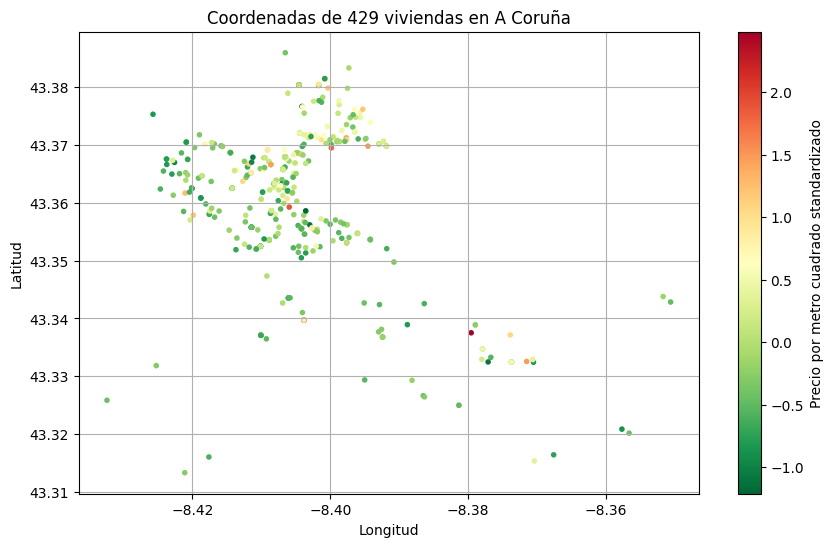

In [144]:
from matplotlib.colors import LogNorm

filter = 3

longs = np.array(data['direccion_x'].values.tolist())
lats = np.array(data['direccion_y'].values.tolist())
precio_m2 = np.array((data['precio']/data['tamano']).values.tolist())
normalized_precios = (precio_m2 - np.mean(precio_m2)) / np.std(precio_m2)

lats = lats[np.abs(normalized_precios)<filter]
longs = longs[np.abs(normalized_precios)<filter]
normalized_precios = normalized_precios[np.abs(normalized_precios)<filter]

# Define a colormap ranging from green to red
colormap = plt.cm.get_cmap('RdYlGn_r')

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(lats, longs, c=normalized_precios, cmap=colormap, marker='.')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Coordenadas de ' + str(len(lats)) + ' viviendas en A Coruña')
plt.grid(True)

# Add colorbar to indicate price range
cbar = plt.colorbar(scatter)
cbar.set_label('Precio por metro cuadrado standardizado')

plt.show()


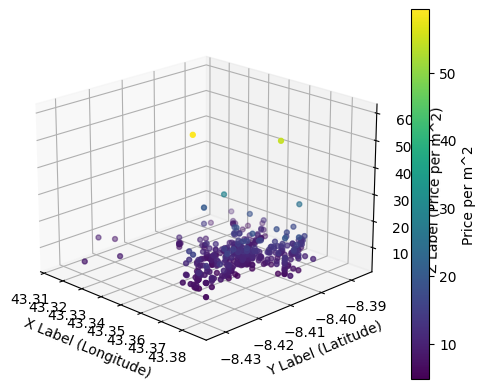

In [78]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(longs, lats, precio_m2, c=precio_m2, cmap='viridis', s=50, marker='.')

# Adjust viewing angle for better visualization
ax.view_init(elev=20, azim=-45)

ax.set_xlabel('X Label (Longitude)')
ax.set_ylabel('Y Label (Latitude)')
ax.set_zlabel('Z Label (Price per m^2)')

# Add color bar to show the mapping of z-values to colors
cbar = fig.colorbar(sc)
cbar.set_label('Price per m^2')

plt.show()

plt.show()

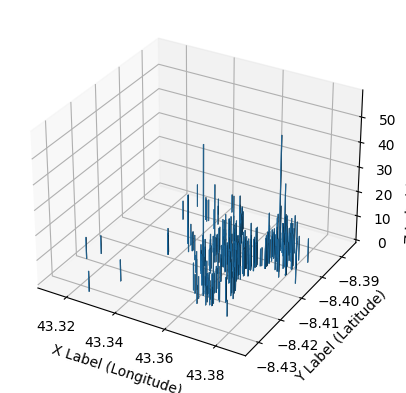

In [98]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot vertical bars
tam_bars = 0.00025
ax.bar3d(longs, lats, [0] * len(precio_m2), tam_bars, tam_bars, precio_m2, shade=True)

ax.set_xlabel('X Label (Longitude)')
ax.set_ylabel('Y Label (Latitude)')
ax.set_zlabel('Z Label (Price per m^2)')

plt.show()

In [57]:
import folium

# Coordenadas de ejemplo
coordinates = [
    (37.7749, -122.4194),  # San Francisco, CA
    (34.0522, -118.2437),  # Los Angeles, CA
    (40.7128, -74.0060),   # New York, NY
    (41.8781, -87.6298)    # Chicago, IL
]

# Crear un objeto de mapa centrado en las coordenadas promedio
center_lat = sum([lat for lat, lon in coordinates]) / len(coordinates)
center_lon = sum([lon for lat, lon in coordinates]) / len(coordinates)
m = folium.Map(location=[center_lat, center_lon], zoom_start=4)

# Agregar marcadores para las coordenadas
for coord in coordinates:
    folium.Marker(coord).add_to(m)

# Guardar el mapa como un archivo HTML
m.save('mapa.html')
